>[Set up](#scrollTo=o5GhFjBfUYEJ)

>[Config](#scrollTo=MQm6LXj0YGZ6)

>[Main](#scrollTo=TzwgwAO6YXsg)

>[KNN/Transferability](#scrollTo=wbk4ENP0swZi)



# Set up

imports

In [54]:
!pip install keras
import keras
from keras.datasets import mnist
import keras.backend as K
from keras.layers import (Dense,Activation,
                          Flatten,Input)
from keras.callbacks import EarlyStopping
from keras.optimizers import Optimizer
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

functions

In [0]:
def get_dataset(data_name):
  ''' Pulls the MNIST dataset and selects which digits to use
  '''
  if data_name.startswith('mnist'):
      train_data,test_data = mnist.load_data()
      X_train,y_train = train_data
      X_test,y_test = test_data
      X_train = np.float32(X_train/255.)
      X_test = np.float32(X_test/255.)
      y_train = np.float32(y_train)
      y_test = np.float32(y_test)

      mnist_vals = data_name.replace('mnist','')
      if mnist_vals:
          mnist_ints = [int(idx) for idx in mnist_vals]
          valid_train = np.isin(y_train,mnist_ints)
          valid_test = np.isin(y_test,mnist_ints)

          X_train = X_train[valid_train]
          y_train = y_train[valid_train]
          X_test = X_test[valid_test]
          y_test = y_test[valid_test]
      else:
          mnist_ints =list(range(10))

      y_train = to_categorical(y_train)
      y_test = to_categorical(y_test)

  return X_train,y_train,X_test,y_test,mnist_ints
  
def swap_y(y_set,unique_vectors):
  ''' For the y vectors, swap each one hot encoding with another 
      (random and incorrect) y value.
  '''
  y_shape = np.shape(y_set)
  y_len,num_cat = y_shape

  y_new = np.zeros(y_shape)
  y_new_probs = np.argmax(np.random.multinomial(1,
                                      [1/np.float(num_cat-1)]*(num_cat-1),
                                      size=y_len),
                                      axis=1)
  for idx in range(y_len):
      not_eq = np.any(np.not_equal(y_set[idx],unique_vectors),axis=1)
      not_eq_idx = np.where(not_eq)[0]
      y_new[idx] = unique_vectors[not_eq_idx[y_new_probs[idx]]]

  return y_new

def logreg_model(input_shape,num_categories,
                 input_tensor=None):
  ''' Keras logistic regression model
  '''
  if input_tensor is None:
      inpt = Input(shape=input_shape)
  else:
      if not K.is_keras_tensor(input_tensor):
          inpt = Input(tensor=input_tensor)
      else:
          inpt = input_tensor
  x = Flatten()(inpt)
  x = Dense(num_categories)(x)
  x = Activation('softmax')(x)
  model = keras.models.Model(inpt,x)
  return model

def select_adversarial_candidates(model,X,Y,num_examples):
  ''' Goes through the X data and checks for all x which the model _correctly_
      predicts the corresponding y value. These are good candidates for generating 
      adversaries.
  '''
  predictions = model.predict(X)
  x_shape,y_shape = np.shape(X),np.shape(Y)
  new_X = np.zeros((num_examples,x_shape[1],x_shape[2]))
  new_Y = np.zeros((num_examples,y_shape[1]))
  new_idx = 0

  for idx in range(x_shape[0]):
      if np.argmax(predictions[idx]) == np.argmax(Y[idx]):
          new_X[new_idx] = X[idx]
          new_Y[new_idx] = Y[idx]
          new_idx+=1
      if new_idx >= num_examples:
          break
  return new_X[:new_idx],new_Y[:new_idx]


class Adv_Adam(Optimizer):
  ''' Slight modification of keras Adam which returns the grad instead
      of updating as part of the tf call
  '''
  def __init__(self,
               lr=0.001,
               beta_1=0.9,
               beta_2=0.999,
               epsilon=1e-8,
               decay=0.,
               **kwargs):
    super(Adv_Adam, self).__init__(**kwargs)
    self.iterations = K.variable(0, name='iterations')
    self.lr = K.variable(lr, name='lr')
    self.beta_1 = K.variable(beta_1, name='beta_1')
    self.beta_2 = K.variable(beta_2, name='beta_2')
    self.epsilon = epsilon
    self.decay = K.variable(decay, name='decay')
    self.initial_decay = decay
    
  def get_updates(self, params, loss,shapes=None):
    grads = self.get_gradients(loss, params)
    self.updates = [K.update_add(self.iterations, 1)]

    lr = self.lr
    if self.initial_decay > 0:
      lr *= (1. / (1. + self.decay * self.iterations))

    t = self.iterations + 1
    lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                 (1. - K.pow(self.beta_1, t)))
    if shapes is None:
        shapes = [K.int_shape(p) for p in params]
    ms = [K.zeros(shape) for shape in shapes]
    vs = [K.zeros(shape) for shape in shapes]
    self.weights = [self.iterations] + ms + vs

    for p, g, m, v in zip(params, grads, ms, vs):
      m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
      v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
      grad= lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

      self.updates.append(K.update(m, m_t))
      self.updates.append(K.update(v, v_t))

      return grad,self.updates
  
def fit_adv(images,model,loss,
            num_iter=100,
            optimizer=None):
    '''Optimizes the images (generates adversaries)
    '''
    if optimizer is None:
        optimizer = Adv_Adam()
        
    model_input = model.input
    grad,optimizer_updates = optimizer.get_updates(loss=[loss],
                                 params=[model_input],
                                 shapes = [images.shape])

    iter_func = K.function([model_input],
                 [loss,grad],
                 updates=optimizer_updates)
    
    for i in range(num_iter):
        loss,g = iter_func([images])
        images = images - g
        if i %10 == 0:
            print('iter ',str(i),', current adversary loss : ', loss)
            
    return images

# Config

Default : using only the '0','1', and '2' digits of the MNIST dataset. Generate 200 adversarial examples

In [0]:
data_str = 'mnist012'
num_adversaries = 200

# Main

First we get our mnist data and set up the shape for our model

In [0]:
X_train,y_train,X_test,y_test,mnist_ints = get_dataset(data_str)

input_shape = np.shape(X_train)[1:]
num_categories = np.shape(y_train)[1]


Train the model. Here we use a simple logistic regression model (2D images are flattened). Should get a validation accuracy of 0.99 if using default settings.

In [58]:
model = logreg_model(input_shape=input_shape,
                     num_categories=num_categories)

model.compile('adam','categorical_crossentropy',['acc'])
early_stop = EarlyStopping(patience=5)
model.fit(X_train,y_train,
          epochs=100,
          callbacks=[early_stop],
          validation_data=(X_test,y_test))

Train on 18623 samples, validate on 3147 samples
Epoch 1/100
18623/18623 [==============================] - 1s 62us/step - loss: 0.1642 - acc: 0.9599 - val_loss: 0.0639 - val_acc: 0.9867
Epoch 2/100
18623/18623 [==============================] - 1s 44us/step - loss: 0.0632 - acc: 0.9823 - val_loss: 0.0475 - val_acc: 0.9876
Epoch 3/100
18623/18623 [==============================] - 1s 47us/step - loss: 0.0514 - acc: 0.9846 - val_loss: 0.0395 - val_acc: 0.9901
Epoch 4/100
18623/18623 [==============================] - 1s 49us/step - loss: 0.0452 - acc: 0.9865 - val_loss: 0.0361 - val_acc: 0.9901
Epoch 5/100
18623/18623 [==============================] - 1s 48us/step - loss: 0.0415 - acc: 0.9875 - val_loss: 0.0350 - val_acc: 0.9895
Epoch 6/100
18623/18623 [==============================] - 1s 48us/step - loss: 0.0389 - acc: 0.9881 - val_loss: 0.0336 - val_acc: 0.9905
Epoch 7/100
18623/18623 [==============================] - 1s 46us/step - loss: 0.0366 - acc: 0.9885 - val_loss: 0.0334 - v

18623/18623 [==============================] - 1s 49us/step - loss: 0.0336 - acc: 0.9899 - val_loss: 0.0328 - val_acc: 0.9921
Epoch 10/100
18623/18623 [==============================] - 1s 51us/step - loss: 0.0324 - acc: 0.9905 - val_loss: 0.0336 - val_acc: 0.9898
Epoch 11/100
18623/18623 [==============================] - 1s 49us/step - loss: 0.0313 - acc: 0.9908 - val_loss: 0.0315 - val_acc: 0.9911
Epoch 12/100
18623/18623 [==============================] - 1s 49us/step - loss: 0.0307 - acc: 0.9904 - val_loss: 0.0342 - val_acc: 0.9898
Epoch 13/100
18623/18623 [==============================] - 1s 46us/step - loss: 0.0299 - acc: 0.9911 - val_loss: 0.0316 - val_acc: 0.9905
Epoch 14/100
18623/18623 [==============================] - 1s 48us/step - loss: 0.0292 - acc: 0.9912 - val_loss: 0.0306 - val_acc: 0.9905
Epoch 15/100
18623/18623 [==============================] - 1s 48us/step - loss: 0.0285 - acc: 0.9915 - val_loss: 0.0302 - val_acc: 0.9911
Epoch 16/100
18623/18623 [==============

18623/18623 [==============================] - 1s 48us/step - loss: 0.0276 - acc: 0.9917 - val_loss: 0.0303 - val_acc: 0.9901
Epoch 18/100
18623/18623 [==============================] - 1s 47us/step - loss: 0.0269 - acc: 0.9921 - val_loss: 0.0317 - val_acc: 0.9898
Epoch 19/100
18623/18623 [==============================] - 1s 49us/step - loss: 0.0263 - acc: 0.9923 - val_loss: 0.0336 - val_acc: 0.9892
Epoch 20/100
18623/18623 [==============================] - 1s 49us/step - loss: 0.0260 - acc: 0.9926 - val_loss: 0.0311 - val_acc: 0.9901


Use the trained model to create adversaries

In [0]:
model_weights = model.get_weights()


Pick some correctly predicted samples to use for generating adversaries

In [0]:
X_cand,y_cand = select_adversarial_candidates(model,X_test,
                                            y_test,num_adversaries)
initial_predictions = model.predict(X_cand)
unique_vectors = np.unique(y_train,axis=0)

y_new = swap_y(y_cand,unique_vectors)

Generate our adversaries

In [61]:
loss = K.sum(K.categorical_crossentropy(y_new,model.output))

adversary_x = fit_adv(X_cand,model,loss)

('iter ', '0', ', current adversary loss : ', 2181.4309)
('iter ', '10', ', current adversary loss : ', 1833.0919)
('iter ', '20', ', current adversary loss : ', 1516.386)
('iter ', '30', ', current adversary loss : ', 1270.3728)
('iter ', '40', ', current adversary loss : ', 1103.0864)
('iter ', '50', ', current adversary loss : ', 1000.6942)
('iter ', '60', ', current adversary loss : ', 947.9447)
('iter ', '70', ', current adversary loss : ', 929.11908)
('iter ', '80', ', current adversary loss : ', 924.25616)
('iter ', '90', ', current adversary loss : ', 922.74603)


Check our adversaries, pick out the adversaries that sucessfully tricked the model

Adversaries worked : 143 out of 200
Here is the original image
('model predicted the original as ', 2)


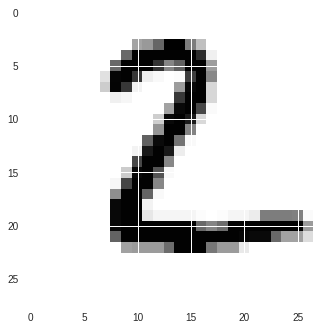

In [62]:
adversary_y = model.predict(adversary_x)

successful_adv = []
for adv_idx in range(num_adversaries):
  if np.argmax(adversary_y[adv_idx]) != np.argmax(y_cand[adv_idx]):
      successful_adv.append(adv_idx)
num_sucessful_adv = len(successful_adv)
print("Adversaries worked : {:d} out of {:d}".format(num_sucessful_adv,num_adversaries))

successful_adv_x = adversary_x[successful_adv]
successful_adv_y = adversary_y[successful_adv]
original_x = X_cand[successful_adv]
original_y = y_cand[successful_adv]
if len(successful_adv) > 0:
  print('Here is the original image')
  plt.imshow(original_x[0])
  print('model predicted the original as ' ,
        mnist_ints[np.argmax(original_y[0])])

 

Plot an example adversary

Here is the adversarial version
('model incorrectly predicts this adversary as ', 1)


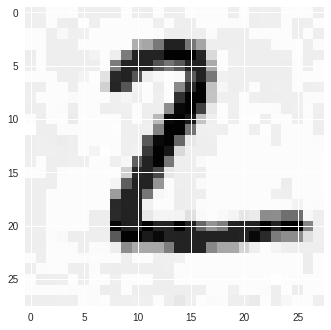

In [63]:
if len(successful_adv) > 0:
  print('Here is the adversarial version')
  plt.imshow(successful_adv_x[0])
  print('model incorrectly predicts this adversary as ',
        mnist_ints[np.argmax(adversary_y[0])])

# KNN/Transferability

Here we test whether the the same adversarial examples can trick another simple model, K-Nearest Neighbors.
First set up for sklearn's KNN method.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
X_train_flat = X_train.reshape(X_train.shape[0],-1)
X_test_flat = X_test.reshape(X_test.shape[0],-1)
X_cand_flat = X_cand.reshape(X_cand.shape[0],-1)
successful_adv_x_flat = successful_adv_x.reshape(successful_adv_x.shape[0],-1)
original_x_flat = original_x.reshape(original_x.shape[0],-1)


Now train the model on the MNIST training set.

In [0]:
k = 5
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_flat,y_train)

Have the KNN model predict on the candidate original X samples (X data before they were transformed into adversarial examples)

In [66]:
original_y_pred = knn.predict(original_x_flat)
num_original_failed = np.sum(np.argmax(original_y_pred,axis=1)
                            !=np.argmax(original_y,axis=1))

print('KNN Success rate on the original X candidates: {:d} of {:d}'.format(
        num_sucessful_adv-num_original_failed,num_sucessful_adv))

KNN Success rate on the original X candidates: 142 of 143


Now have the KNN model predict on the transformed/adversarial examples.


In [67]:
successful_adv_y_pred = knn.predict(successful_adv_x_flat)
successful_adv_y_incorrect = (np.argmax(successful_adv_y_pred,axis=1)
                                !=np.argmax(original_y,axis=1))

num_successful_adv_failed = np.sum(successful_adv_y_incorrect)
print('KNN Success rate on the adversarial X candidates: {:d} of {:d}'.format(
    num_sucessful_adv-num_successful_adv_failed,num_sucessful_adv))

KNN Success rate on the adversarial X candidates: 141 of 143


It looks like most of the time, the adversarial examples do not transfer over to the KNN model. Of course this is just a simple example, under other circumstances it has been found that adversarial examples do transfer.